# <Center>Assignment 1: Text Analysis over Political Speaches
    
### <Center>Ian Brandenburg
    
This text analysis assignment takes a look into senators' speeches compared to Biden's speeches. The objective is to determine which senators have the most similar speeches to Biden using cosine similarity. The speeches for each senator were use in aggregation of the senator instead of splitting up the speeches. Thus, the entire senator file was create as one document. The text will be processed utilizing three different text processing techniques. The first method is a basic text processing method, which tokenizes all of the text after lowercasing, removing numbers, punctuation, and SK Learn stopwords. The second text processing method utilizes stemming while the third utilizes lemmatization. Both of these methods are used on the already preprocessed text. 
    
Once the text processing was complete, visualizations were developed in order to visualize the most similar senators' speeches to Biden's speeches. Additionally, these similarities were integrated with the sen105kh_fix.csv to see if the most similar speeches belong to senators from the same party and/or state. These validations were also visualized. 
    
Finally, three predictive model measures were utilized to analyze the predictive power the speeches have in determining the party of the senator. These three models include: Linear Regression, Multinomial Naive Bayes, and Gaussian Naive Bayes. Each of them were run to compare their results. 

---

You will be working with senator speeches located in the '105-extracted-date' folder within the 'Inputs' directory. Please complete the following tasks:

i) Use cosine similarity to determine which senator's speech is closest to Senator Biden's. Describe your findings. Make sure to describe your text preprocessing and justify your choices. Validate your findings using 'sen105kh_fix.csv' and/or Wikipedia to see if the most similar speeches belong to senators from the same state and/or party. 

ii) How do your results change if you apply stemming or lemmatization? In your opinion, which is better to apply: stemming or lemmatization? Why?

iii) Create at least two visualizations to support your analysis.

iv) Use 'sen105kh_fix.csv' as the target variable for your predictions. Can you predict the 'party' of the senator from their speech? Should you use the same text preprocessing as above? Justify your choices. Probably going to use MultinomialNB() for prediction. In class, we predicted the label.

v) Write a Medium article summarizing your findings. This article should be written with a general audience in mind. The best articles may be invited for submission to CEU Economic Threads.

vi) Bonus 10 points: Read one of the articles that I have linked in this Medium post. Contrast your findings in i) with theirs and discuss any discrepancies. What are possible solutions?


In [1]:
import os
import time
import re
import string
import pandas as pd
import numpy as np
import requests
import matplotlib as plt
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet

# Initialize the tfidf vectorizers
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer_stem = TfidfVectorizer()
tfidf_vectorizer_lem = TfidfVectorizer()

# Initialize stemmer and lemmatizer
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# Initialize the Multinomial Naive Bayes classifier
model = MultinomialNB()

import warnings
warnings.filterwarnings('ignore')

In [2]:
def read_speech(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def preprocess_text(text):
    """
    Input: text
    Output: Tokenized text that has been scrubbed. The text is
    lower cased, and punctuation, numbers, and stopwords are removed.
    """
    text = text.lower()
    tokens = [word for word in text.split() if word.isalpha() and word not in ENGLISH_STOP_WORDS]
    #tokens = [word for word in tokens if len(word)>=3]
    return ' '.join(tokens)

def cosine_similarity_calc(tfidf_matrix, reference_index, labels):
    """
    Calculate the cosine similarity of all speeches in the tfidf_matrix with respect to the speech at reference_index.
    
    Inputs:
    - tfidf_matrix (array): The TF-IDF matrix where rows represent documents/speeches.
    - reference_index (int): The index of the reference speech in the tfidf_matrix.
    - labels (iterable): Identifiers for each speech/document in the tfidf_matrix.
    
    Returns:
    - List of tuples: Each tuple contains (label, similarity score) sorted by similarity score in descending order.
    """
    
    # calculating the cosine similarity of the reference speech with all speeches
    cosine_similarities = cosine_similarity(tfidf_matrix[reference_index:reference_index+1], tfidf_matrix).flatten()
    
    # creating a dictionary to hold the similarity scores, skipping the reference speech
    similarity_scores = {label: score for label, score in zip(labels, cosine_similarities) if label != labels[reference_index]}
    
    # sort the labels by similarity score in descending order
    sorted_similarities = sorted(similarity_scores.items(), key=lambda item: item[1], reverse=True)
    
    return sorted_similarities


def stem_text(text):
    """
    Apply Porter's Stemming to the given text.
    
    Args:
    - text (str): Preprocessed text to stem.
    
    Returns:
    - str: The stemmed text.
    """
    stemmer = PorterStemmer()
    tokens = text.split()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)


def lemmatize_text(text):
    """
    Apply WordNet Lemmatizing to the given text.
    
    Args:
    - text (str): Preprocessed text to lemmatize.
    
    Returns:
    - str: The lemmatized text.
    """
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


def print_senator_details(top_5_senators, senators_info):
    """
    Prints details for the top 5 senators, including party and state, and their commonalities with Biden.
    
    Args:
    - top_5_senators (list of str): A list of senator identifiers in the format 'last_name-state_abbr'.
    - senators_info (pd.DataFrame): A DataFrame containing information about senators, with columns 
      ['cong', 'name', 'state_abbr', 'state', 'id', 'dist', 'party'].
    """
    # Identify Biden's party and state for reference
    biden_info = senators_info[senators_info['name'].str.contains('biden', case=False)]
    biden_party = biden_info['party'].iloc[0]
    biden_state_abbr = biden_info['state_abbr'].iloc[0]
    
    print('-'*75)
    print(f"Biden's party: {biden_party}")
    print(f"Biden's state abbreviation: {biden_state_abbr}")
    print('-'*75)
    
    # Extract information for the top 5 senators
    for senator in top_5_senators:
        # Each senator string is formatted as 'last_name-state_abbr'
        senator_last_name, senator_state_abbr = senator.split('-')
        
        # Look up this senator in the senators_info DataFrame
        senator_info = senators_info[
            (senators_info['name'].str.lower().str.contains(senator_last_name)) & 
            (senators_info['state_abbr'].str.lower() == senator_state_abbr.lower())
        ]
        
        if not senator_info.empty:
            senator_party = senator_info['party'].iloc[0]
            print(f"Senator {senator} is from {senator_state_abbr.upper()} and belongs to party {senator_party}")
            print(f"Commonality with Biden - State: {'Yes' if senator_state_abbr.lower() == biden_state_abbr.lower() else 'No'}, Party: {'Yes' if senator_party == biden_party else 'No'}")
            print('-'*75)
        else:
            print(f"No information found for Senator {senator}")



In [3]:
# path to the directory containing the speeches
speeches_dir = 'C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/105-extracted-date'

# dictionary to hold senator name and their speech
senator_speeches = {}

### 1) Use cosine similarity to determine which senator's speech is closest to Senator Biden's. 

Describe your findings. Make sure to describe your text preprocessing and justify your choices. Validate your findings using `sen105kh_fix.csv` and/or Wikipedia to see if the most similar speeches belong to senators from the same state and/or party. 

#### Read speeches into the senator_speeches library

Here, the senator speeches are read through the read speech function, and fed into the senator_speeches library, using the name of the documents (which includes the senators' name) as the key.

In [4]:
for file_name in os.listdir(speeches_dir):
    if file_name.endswith('.txt'):
        # Extract senator name from file name or another way you have structured it
        senator_name = file_name.replace('.txt', '')
        file_path = os.path.join(speeches_dir, file_name)
        senator_speeches[senator_name] = read_speech(file_path)

# check the first 5 senator names to make sure it worked
labels = list(senator_speeches.keys())
labels[:5]

['105-abraham-mi',
 '105-akaka-hi',
 '105-allard-co',
 '105-ashcroft-mo',
 '105-baucus-mt']

#### Preprocess the speeches

Using the preprocess function, preprocess all speeches in the library

In [5]:
# preprocessing all speeches
processed_speeches = {senator: preprocess_text(speech) for senator, speech in senator_speeches.items()}


#### Convert to TFIDF vectors and set biden's speech

Convert the processed speeches to a tfidf matrix using the tfidf vectorizer, initialized along with the import libraries portion of the code. 

Additionally, this chunk of code sets biden's speeches as biden_index so that there is a speech to compare the others to in the cosine similarity. 

In [6]:
# convert to TF-IDF vectors
tfidf_matrix_norm = tfidf_vectorizer.fit_transform(processed_speeches.values())

# setting biden's speach to `biden_index` for consine similarity comparison
biden_index = list(processed_speeches.keys()).index('105-biden-de') 


#### Applying the Cosine Similarity Function and printing the top 5 senators and their similarity scores to biden's speeches. 

Here, the `cosine_similarity_calc` function is applied, using the tfidf_matrix, biden_index, and the labels (which was initalized earlier as the the list of the document names). 

In [7]:
# Initialize the comparison table
columns = ['Senator', 'Score', 'Type']
results_df = pd.DataFrame(columns=columns)

In [8]:
top_similarities = cosine_similarity_calc(tfidf_matrix_norm, biden_index, labels)

for senator, score in top_similarities[:5]:
    # Create a temporary DataFrame for the current row and concatenate it with the results_df since append was not working
    temp_df = pd.DataFrame({'Senator': [senator], 'Score': [score], 'Type': ['Normal']})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
results_df


,Senator,Score,Type
0,105-kerry-ma,0.792525,Normal
1,105-kyl-az,0.784532,Normal
2,105-hutchison-tx,0.782242,Normal
3,105-lieberman-ct,0.781326,Normal
4,105-roberts-ks,0.776708,Normal


In [9]:
# extracting senator names and state abbreviations using regex
top_5_senators_norm = [re.search(r'\d+-(\w+-\w+)', senator).group(1) for senator, _ in top_similarities[:5]]

print(top_5_senators_norm)

['kerry-ma', 'kyl-az', 'hutchison-tx', 'lieberman-ct', 'roberts-ks']


#### Reading in the senator information CSV

Here, the senator information CSV is read in, being separated by ';'. This is for comparing senator information to biden's to see if there are any visable similarites or consistentcies in the party or state of the top five most similar speeches to Biden's. 

In [10]:
# path to the CSV file
csv_path = "C:/Users/iandr/masters_coding/Second Semester/Python_Programming_Viz_Text/Course_Materials/Inputs/sen105kh_fix.csv"

# loading the CSV for validation, using ';' as the separator 
senators_info = pd.read_csv(csv_path, sep=';')

# establishing the csv column names, and the top five senators' name
senators_info.columns = ['cong', 'name', 'state_abbr', 'state', 'id', 'dist', 'party']

# check the dataframe
print(senators_info.head())


   cong       name state_abbr    state     id  dist  party
0   105   sessions         al  ALABAMA  49700     0    200
1   105     shelby         al  ALABAMA  94659     0    200
2   105  murkowski         ak  ALASKA   14907     0    200
3   105    stevens         ak  ALASKA   12109     0    200
4   105        kyl         az  ARIZONA  15429     0    200


In [11]:
print_senator_details(top_5_senators_norm, senators_info)

---------------------------------------------------------------------------
Biden's party: 100
Biden's state abbreviation: de
---------------------------------------------------------------------------
Senator kerry-ma is from MA and belongs to party 100
Commonality with Biden - State: No, Party: Yes
---------------------------------------------------------------------------
Senator kyl-az is from AZ and belongs to party 200
Commonality with Biden - State: No, Party: No
---------------------------------------------------------------------------
Senator hutchison-tx is from TX and belongs to party 200
Commonality with Biden - State: No, Party: No
---------------------------------------------------------------------------
Senator lieberman-ct is from CT and belongs to party 100
Commonality with Biden - State: No, Party: Yes
---------------------------------------------------------------------------
Senator roberts-ks is from KS and belongs to party 200
Commonality with Biden - State: No,

#### Party and State similarities

The top five senators do not seem to have very many consistencies with Biden's speeches. Since there are only two parties, it could be considered a coincidence that there are similar parties to Biden's in the top five senators listed here. Only two senators have the same party, and no senator has the same state as Biden. 

### 2) How do your results change if you apply stemming or lemmatization? In your opinion, which is better to apply: stemming or lemmatization? Why?
---

In [12]:
# Applying stemming
start_time = time.time()
stemmed_speeches = {senator: stem_text(speech) for senator, speech in processed_speeches.items()}
print(f"Stemming completed. Time taken: {time.time() - start_time:.2f}s")


Stemming completed. Time taken: 175.57s


In [13]:
# Applying lemmatizing
start_time = time.time()
lemmatized_speeches = {senator: lemmatize_text(speech) for senator, speech in processed_speeches.items()}
print(f"Lemmatization completed. Time taken: {time.time() - start_time:.2f}s")


Lemmatization completed. Time taken: 39.21s


# ***ADD B.O.W. HERE***!!!!!

# ***ADD TFIDF FOR B.O.W. HERE***!!!

In [14]:
# Vectorize the speeches
start_time = time.time()
tfidf_matrix_stem = tfidf_vectorizer_stem.fit_transform(list(stemmed_speeches.values()))
tfidf_matrix_lemmatize = tfidf_vectorizer_lem.fit_transform(list(lemmatized_speeches.values()))
print(f"TF-IDF vectorization completed. Time taken: {time.time() - start_time:.2f}s")


TF-IDF vectorization completed. Time taken: 10.97s


In [15]:
# Cosine Similarity on Stemmed Speeches
top_similarities_stem = cosine_similarity_calc(tfidf_matrix_stem, biden_index, labels)
top_5_senators_stem = [re.search(r'\d+-(\w+-\w+)', senator).group(1) for senator, _ in top_similarities_stem[:5]]

# Cosine Similarity on Lemmatized Speeches
top_similarities_lemmatize = cosine_similarity_calc(tfidf_matrix_lemmatize, biden_index, labels)
top_5_senators_lemmatize = [re.search(r'\d+-(\w+-\w+)', senator).group(1) for senator, _ in top_similarities_lemmatize[:5]]


In [16]:
print("Similarity Scores using Stemming:")
for senator, score in top_similarities_stem[:5]:
    # Create a temporary DataFrame for the current row and concatenate it with the results_df since append was not working
    temp_df = pd.DataFrame({'Senator': [senator], 'Score': [score], 'Type': ['Stemming']})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
print(results_df)

print('-'*75)
print_senator_details(top_5_senators_stem, senators_info)

Similarity Scores using Stemming:
            Senator     Score      Type
0      105-kerry-ma  0.792525    Normal
1        105-kyl-az  0.784532    Normal
2  105-hutchison-tx  0.782242    Normal
3  105-lieberman-ct  0.781326    Normal
4    105-roberts-ks  0.776708    Normal
5      105-kerry-ma  0.842858  Stemming
6        105-kyl-az  0.834385  Stemming
7  105-lieberman-ct  0.831528  Stemming
8    105-roberts-ks  0.828646  Stemming
9       105-byrd-wv  0.825766  Stemming
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Biden's party: 100
Biden's state abbreviation: de
---------------------------------------------------------------------------
Senator kerry-ma is from MA and belongs to party 100
Commonality with Biden - State: No, Party: Yes
---------------------------------------------------------------------------
Senator kyl-az is from AZ and belongs to party 200
Commonality with Bide

In [17]:
print("Similarity Scores using Lemmatizing:")
for senator, score in top_similarities_lemmatize[:5]:
    temp_df = pd.DataFrame({'Senator': [senator], 'Score': [score], 'Type': ['Lemmatizing']})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
print(results_df)

print('-'*75)
print_senator_details(top_5_senators_lemmatize, senators_info)

Similarity Scores using Lemmatizing:
             Senator     Score         Type
0       105-kerry-ma  0.792525       Normal
1         105-kyl-az  0.784532       Normal
2   105-hutchison-tx  0.782242       Normal
3   105-lieberman-ct  0.781326       Normal
4     105-roberts-ks  0.776708       Normal
5       105-kerry-ma  0.842858     Stemming
6         105-kyl-az  0.834385     Stemming
7   105-lieberman-ct  0.831528     Stemming
8     105-roberts-ks  0.828646     Stemming
9        105-byrd-wv  0.825766     Stemming
10      105-kerry-ma  0.807746  Lemmatizing
11        105-kyl-az  0.801307  Lemmatizing
12  105-lieberman-ct  0.799500  Lemmatizing
13  105-hutchison-tx  0.799329  Lemmatizing
14    105-roberts-ks  0.793694  Lemmatizing
---------------------------------------------------------------------------
---------------------------------------------------------------------------
Biden's party: 100
Biden's state abbreviation: de
---------------------------------------------------------

In [18]:
results_df

,Senator,Score,Type
0,105-kerry-ma,0.792525,Normal
1,105-kyl-az,0.784532,Normal
2,105-hutchison-tx,0.782242,Normal
3,105-lieberman-ct,0.781326,Normal
4,105-roberts-ks,0.776708,Normal
5,105-kerry-ma,0.842858,Stemming
6,105-kyl-az,0.834385,Stemming
7,105-lieberman-ct,0.831528,Stemming
8,105-roberts-ks,0.828646,Stemming
9,105-byrd-wv,0.825766,Stemming


In [19]:
df_stem_similarity = pd.DataFrame(top_similarities_stem, columns=['name', 'similarity'])
df_stem_similarity['name'] = df_stem_similarity['name'].apply(lambda x: re.search(r'-(\w+)-', x).group(1))
df_stem_similarity = df_stem_similarity[['name', 'similarity']]
df_stem_similarity['similarity'] = df_stem_similarity['similarity'].round(4)
df_stem_similarity.head()

,name,similarity
0,kerry,0.8429
1,kyl,0.8344
2,lieberman,0.8315
3,roberts,0.8286
4,byrd,0.8258


In [20]:
df_stem_similarity_merged = df_stem_similarity.merge(senators_info, on='name', how='left')

df_stem_similarity_merged.head()

,name,similarity,cong,state_abbr,state,id,dist,party
0,kerry,0.8429,105,ma,MASSACH,14920,0,100
1,kyl,0.8344,105,az,ARIZONA,15429,0,200
2,lieberman,0.8315,105,ct,CONNECT,15704,0,100
3,roberts,0.8286,105,ks,KANSAS,14852,0,200
4,byrd,0.8258,105,wv,WEST VI,1366,0,100


In [21]:
df_stem_similarity_merged.columns

Index(['name', 'similarity', 'cong', 'state_abbr', 'state', 'id', 'dist',
       'party'],
      dtype='object')

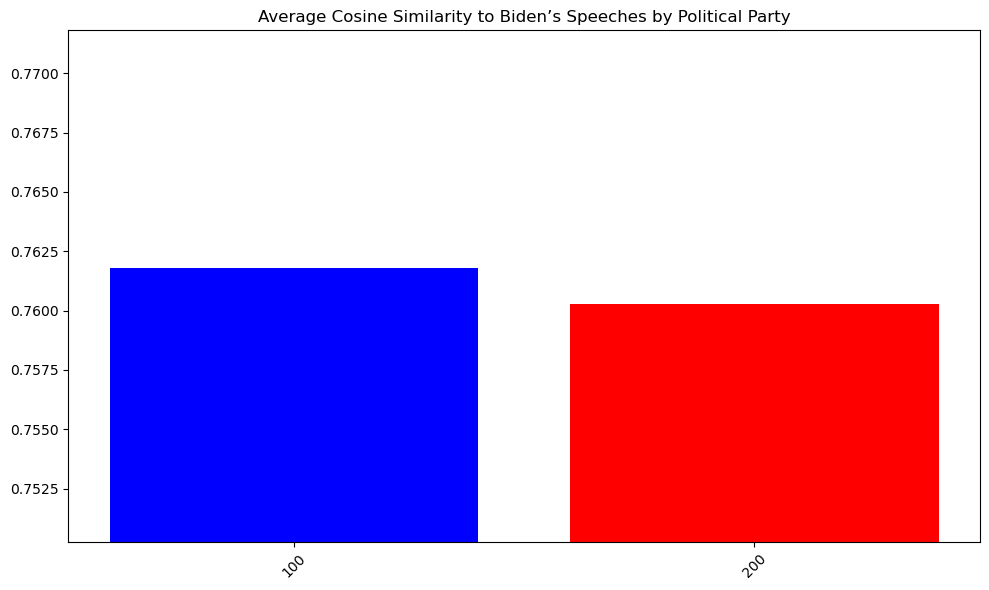

In [22]:
# Convert 'party' to string type
df_stem_similarity_merged['party'] = df_stem_similarity_merged['party'].astype(str)

# Calculate the average cosine similarity by party
avg_similarity_by_party = df_stem_similarity_merged.groupby('party')['similarity'].mean().reset_index()

# Plot a bar chart
plt.figure(figsize=(10, 6))
plt.bar(avg_similarity_by_party['party'], avg_similarity_by_party['similarity'], color=['blue', 'red'])
plt.xlabel('')
plt.ylabel('')
plt.title('Average Cosine Similarity to Biden’s Speeches by Political Party')
plt.xticks(rotation=45)
plt.ylim(avg_similarity_by_party['similarity'].min() - 0.01, avg_similarity_by_party['similarity'].max() + 0.01)  # Set the limits for y-axis to make differences more pronounced
plt.tight_layout()
plt.show()

### 3) Create at least two visualizations to support your analysis.

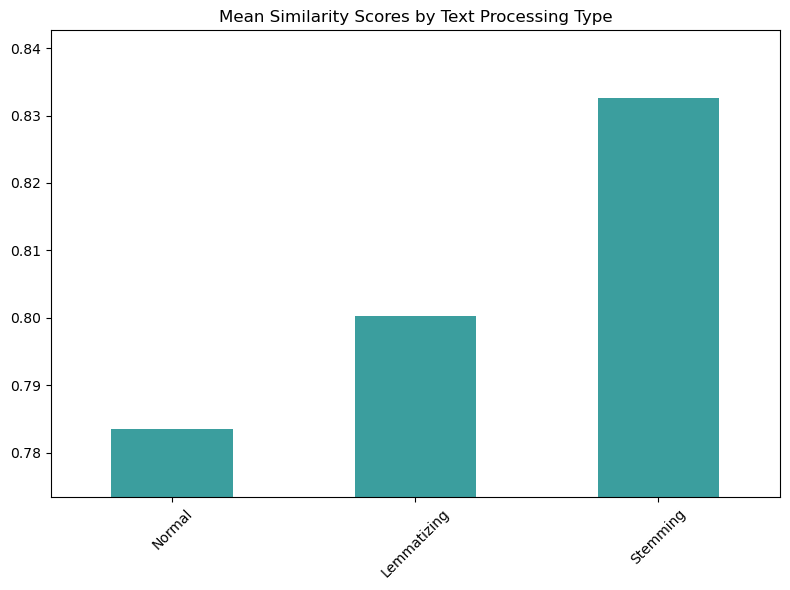

In [42]:
# calculating mean scores for each Type and sort them
mean_scores = results_df.groupby('Type')['Score'].mean().sort_values()

# Plotting
plt.figure(figsize=(8, 6))
mean_scores.plot(kind='bar', color = '#3b9e9e')
plt.title('Mean Similarity Scores by Text Processing Type')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)

# Narrow the y-axis to better visualize differences
plt.ylim(mean_scores.min() - 0.01, mean_scores.max() + 0.01)  # Adjust as needed

plt.tight_layout()
# Save the plot to the current working directory
plt.savefig("mean_similarity_by_processing_type.png")
plt.show()


The bar chart above displays a comparative analysis of the mean similarity scores between the different text processing type: normal processing, stemming, and lemmatizing. From this analysis, the stemming method seems to yield the highest mean similarity score, which is then followed by lemmatizing, and then the normal method without stemming and lemmatizing. This would suggest that both stemming and lemmatizing would enhance the similarity between texts. 

Stemming reduces words to their root forms through the truncation of derivational affixes, which could contribute to a stronger matching process by simplifying the text. This could lead to an increased incidence of word overlap between documents, which would increase the similarity scores as well. Lemmatizationg also converts words to their base form through a more sophisticated methodology. Here, it shows a slightly lesser impact on similarites scores compared to stemming. Overall, these findings suggest the importance of text preprocessing, as well as choosing the optimal and appropriate preprocessing techniques. 

In [24]:
# Add 'State' and 'Party' columns to results_df
results_df['State'] = results_df['Senator'].apply(lambda name: senators_info[senators_info['name'].str.contains(name.split('-')[1], case=False)]['state_abbr'].iloc[0])
results_df['Party'] = results_df['Senator'].apply(lambda name: senators_info[senators_info['name'].str.contains(name.split('-')[1], case=False)]['party'].iloc[0])

# establishing biden's information, party, and state for comparison
biden_info = senators_info[senators_info['name'].str.contains('biden')].iloc[0]
biden_party = biden_info['party']
biden_state = biden_info['state_abbr']

def assign_colors(row, biden_party, biden_state):
    if row['Party'] == biden_party and row['State'] == biden_state:
        return 'green'  # same party and state as Biden
    elif row['Party'] == biden_party:
        return 'blue'   # same party as Biden
    elif row['State'] == biden_state:
        return 'cyan'   # same state as Biden
    else:
        return 'red'
    

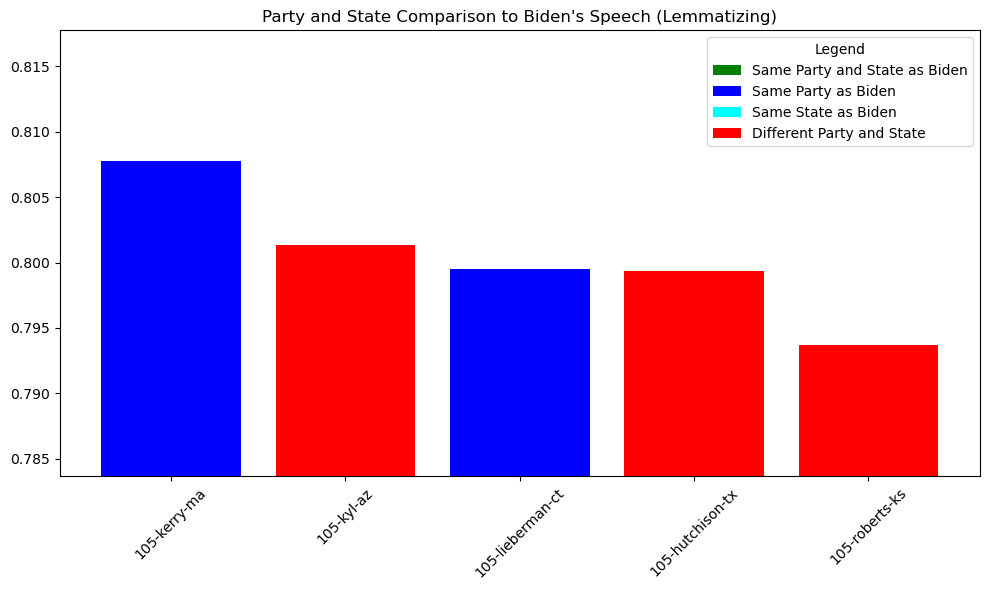

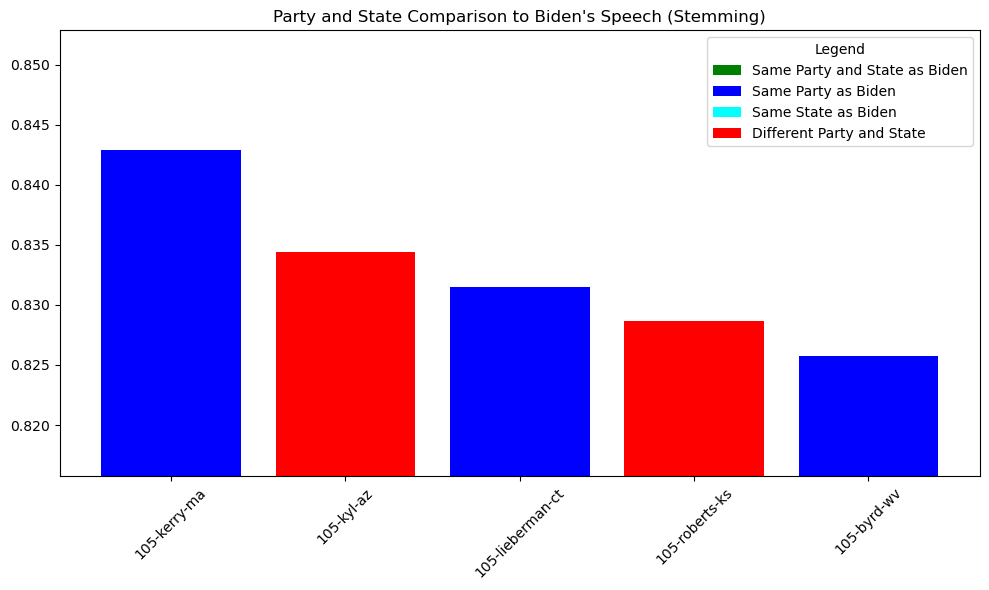

In [44]:
def visualize_comparison(type_filter):
    plt.figure(figsize=(10, 6))
    filtered_df = results_df[results_df['Type'] == type_filter]
    filtered_df['Color'] = filtered_df.apply(lambda row: assign_colors(row, biden_party, biden_state), axis=1)
    
    plt.bar(filtered_df['Senator'], filtered_df['Score'], color=filtered_df['Color'])
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f"Party and State Comparison to Biden's Speech ({type_filter})")
    plt.ylim([filtered_df['Score'].min() - 0.01, filtered_df['Score'].max() + 0.01])

    legend_elements = [Patch(facecolor='green', label='Same Party and State as Biden'),
                       Patch(facecolor='blue', label='Same Party as Biden'),
                       Patch(facecolor='cyan', label='Same State as Biden'),
                       Patch(facecolor='red', label='Different Party and State')]
    plt.legend(handles=legend_elements, title='Legend')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the plot to the current working directory
    plt.savefig(f"{type_filter}_party_state_comparison.png")
    plt.show()

visualize_comparison('Lemmatizing')
visualize_comparison('Stemming')


# !!!!!!!***ADD VIZ SHOWING THE TOP WORDS OF BIDEN AND KERRY***

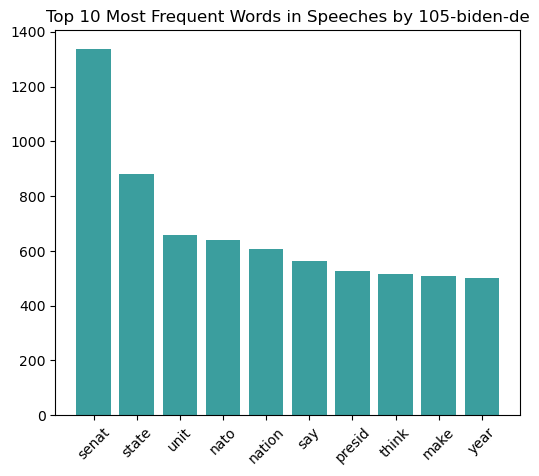

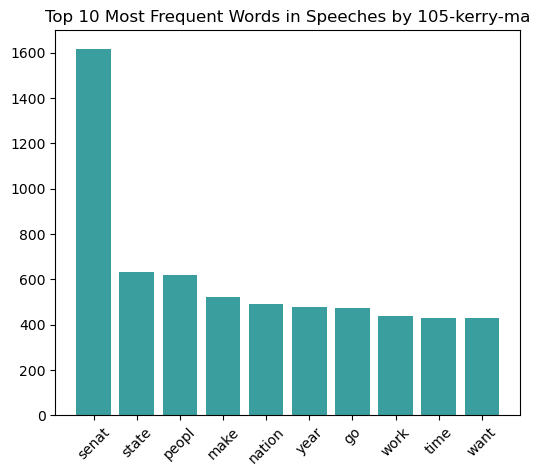

'top_words_105-kerry-ma.png'

In [39]:
# Function to plot the top 10 most frequent words for a given senator's speech
def plot_top_words(senator_key):
    # Tokenize the speech into words
    words = stemmed_speeches[senator_key].split()
    
    # Count the frequency of each word
    word_counts = Counter(words)
    
    # Get the top 10 most common words and their counts
    top_words = word_counts.most_common(10)
    
    # Unzip the words and their counts
    words, counts = zip(*top_words)
    
    # Plotting
    plt.figure(figsize=(6, 5))
    plt.bar(words, counts, color = '#3b9e9e')
    plt.xlabel('')
    plt.ylabel('')
    plt.title(f'Top 10 Most Frequent Words in Speeches by {senator_key}')
    plt.xticks(rotation=45)

    # Save the plot to the current working directory
    plt.savefig(f"top_words_{senator_key}.png")
    plt.show()

# Plot for Biden
plot_top_words("105-biden-de")

# Plot for Kerry
plot_top_words("105-kerry-ma")


### 4) Use 'sen105kh_fix.csv' as the target variable for your predictions. 
- Can you predict the party of the senator from their speech? 
- Should you use the same text preprocessing as above? Justify your choices.
---

In [27]:
y = senators_info['party'].values

In [28]:
def predict_party(tfidf_matrix, y):
    # Convert party labels to numpy array
    y = np.array(y)
    
    # Compute class weights to handle imbalance
    classes = np.unique(y)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
    class_weights_dict = dict(zip(classes, class_weights))
    
    # Initialize the logistic regression model with balanced class weights
    model = LogisticRegression(class_weight=class_weights_dict, random_state=42)
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Print results
    print(report)
    
    return accuracy


In [29]:
# To use the function, call it with each of your precomputed TF-IDF matrices and the label vector 'y'
print(predict_party(tfidf_matrix_norm, y))
print(predict_party(tfidf_matrix_lemmatize, y))
print(predict_party(tfidf_matrix_stem, y))

              precision    recall  f1-score   support

         100       0.45      0.56      0.50         9
         200       0.56      0.45      0.50        11

    accuracy                           0.50        20
   macro avg       0.51      0.51      0.50        20
weighted avg       0.51      0.50      0.50        20

0.5
              precision    recall  f1-score   support

         100       0.55      0.67      0.60         9
         200       0.67      0.55      0.60        11

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.61      0.60      0.60        20

0.6
              precision    recall  f1-score   support

         100       0.50      0.67      0.57         9
         200       0.62      0.45      0.53        11

    accuracy                           0.55        20
   macro avg       0.56      0.56      0.55        20
weighted avg       0.57      0.55      0.55        20

0.55


Precision: This is the ratio of correctly predicted positive observations to the total predicted positive observations. For example, for class 100, the precision in the first classifier is 0.45, meaning that when it predicts class 100, it is correct 45% of the time.

Recall (Sensitivity): This is the ratio of correctly predicted positive observations to the all observations in actual class. For class 100, the recall is 0.56 in the first classifier, meaning that it correctly identifies 56% of all actual instances of class 100.

F1-Score: This is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is a good way to show that a class has a good balance between Precision and Recall. An F1-Score of 0.50 for class 100 in the first classifier indicates that it has an equal balance of Precision and Recall for that class.

Support: This is the number of actual occurrences of the class in the specified dataset. For instance, class 100 has 9 occurrences in the first classifier.

Accuracy: This is the ratio of correctly predicted observation to the total observations and is given for each classifier. The first one has an accuracy of 0.50 (or 50%), which means that the classifier correctly predicts the party 50% of the time across both classes.

Macro Avg: This is the average Precision, Recall, and F1-Score between classes, which treats all classes equally. It doesn’t take label imbalance into account.

Weighted Avg: This is the average Precision, Recall, and F1-Score between classes weighted by the support for each class. This metric does take label imbalance into account.

Based on the provided results:

The first classifier (top block) has an accuracy of 0.50. The F1-Score for both classes is also 0.50, indicating a balance between Precision and Recall but not necessarily a good performance.

The second classifier (middle block) performs slightly better with an accuracy of 0.60 and higher F1-Scores of 0.60 and 0.68 for classes 100 and 200, respectively.

The third classifier (bottom block) has an accuracy of 0.55, with an F1-Score of 0.57 for class 100 and 0.53 for class 200, suggesting it has a balance that is somewhat tilted towards class 100.

In terms of model selection, the second classifier seems to be the best performer out of the three, given its higher accuracy and F1-Score. It would help to know which pre-processing technique (normalized, lemmatized, or stemmed) corresponds to each classifier to make a recommendation on which text processing method yields the best prediction results for the senators' parties.

In [30]:
def predict_party(tfidf_matrix, y):
    # Convert party labels to numpy array
    y = np.array(y)
    
    # Initialize the Multinomial Naive Bayes model
    model = MultinomialNB()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, y, test_size=0.2, random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    # Print results
    print(report)
    
    return accuracy


In [31]:
print(predict_party(tfidf_matrix_norm, y))
print(predict_party(tfidf_matrix_lemmatize, y))
print(predict_party(tfidf_matrix_stem, y))

              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20

0.55
              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20

0.55
              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20

0.55


In [32]:
def predict_party(tfidf_matrix, y):
    # Convert party labels to numpy array
    y = np.array(y)
    
    # Convert the sparse TF-IDF matrix to a dense array
    X_dense = tfidf_matrix.toarray()
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, random_state=42)
    
    # Initialize the Gaussian Naive Bayes model
    gnb = GaussianNB()
    
    # Train the model
    gnb.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = gnb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    
    # Print results
    print("Number of mislabeled points out of a total %d points: %d" % (X_test.shape[0], (y_test != y_pred).sum()))
    print(report)
    
    return accuracy

In [33]:
print(predict_party(tfidf_matrix_norm, y))
print(predict_party(tfidf_matrix_lemmatize, y))
print(predict_party(tfidf_matrix_stem, y))

Number of mislabeled points out of a total 20 points: 12
              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.47      0.73      0.57        11

    accuracy                           0.40        20
   macro avg       0.24      0.36      0.29        20
weighted avg       0.26      0.40      0.31        20

0.4
Number of mislabeled points out of a total 20 points: 12
              precision    recall  f1-score   support

         100       0.00      0.00      0.00         9
         200       0.47      0.73      0.57        11

    accuracy                           0.40        20
   macro avg       0.24      0.36      0.29        20
weighted avg       0.26      0.40      0.31        20

0.4
Number of mislabeled points out of a total 20 points: 9
              precision    recall  f1-score   support

         100       0.50      0.22      0.31         9
         200       0.56      0.82      0.67        11

    